# Why do we not want kids?

Exploring the connection between education and kids: Does the length of womans education, effect the amount of kids, that she gets?

To explore the relationship, we use data from Statistikbanken, on fertility and education length. 

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `dataproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

To run our code, you have to install the DST API wrapper:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2
# The DST API wrapper
%pip install git+https://github.com/alemartinello/dstapi

%pip install matplotlib-venn
# A wrapper for multiple APIs with a pandas interface
%pip install pandas-datareader

# user written modules
import dataproject


  Cloning https://github.com/alemartinello/dstapi to /private/var/folders/g9/q3t9r2bx0bdg9g0lrb95lhzh0000gn/T/pip-req-build-gj3vfzse
  Running command git clone --filter=blob:none --quiet https://github.com/alemartinello/dstapi /private/var/folders/g9/q3t9r2bx0bdg9g0lrb95lhzh0000gn/T/pip-req-build-gj3vfzse
  Resolved https://github.com/alemartinello/dstapi to commit d9eeb5a82cbc70b7d63b2ff44d92632fd77123a4
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

import pandas as pd
from dstapi import DstApi # install with `pip install git+https://github.com/alemartinello/dstapi`

import warnings
warnings.filterwarnings('ignore')

# Read and clean data

Import your data, either through an API or manually, and load it. 

First, we install a CSV files that includes data about danish people education.

In [3]:
#Load the data from Statistik Banken
ind = DstApi('HFUDD11')



Then we start cleaning the data

In [4]:
#Set the language to english
tabsum = ind.tablesummary(language='en')


# The _define_base_params -method gives us a nice template (selects all available data)
params = ind._define_base_params(language='en')
params


# Table of HFUD11 cleaned
from dataproject import HFUD11_data

processed_data = HFUD11_data()
processed_data.head(10)

Table HFUDD11: Educational attainment (15-69 years) by region, ancestry, highest education completed, age, sex and time
Last update: 2023-03-30T08:00:00
Table HFUDD11: Educational attainment (15-69 years) by region, ancestry, highest education completed, age, sex and time
Last update: 2023-03-30T08:00:00


,municipality,year,BA
2,Aalborg,2008,3497
5,Aalborg,2009,3646
8,Aalborg,2010,4001
11,Aalborg,2011,4293
14,Aalborg,2012,4414
17,Aalborg,2013,4661
20,Aalborg,2014,5165
23,Aalborg,2015,5490
26,Aalborg,2016,5842
29,Aalborg,2017,5932


Then we download data about the fertility in Denmark based on area and age

In [5]:
# Table of FOD407 cleaned
from dataproject import FOD407_data

processed_data = FOD407_data()
processed_data.head(10)

Table FOD407: Fertility rates by region, age and time
Last update: 2024-02-12T08:00:00


,municipality,year,fertilitykvotient
38,Aalborg,2006,1681.4
41,Aalborg,2007,1686.6
44,Aalborg,2008,1765.2
47,Aalborg,2009,1724.8
11,Aalborg,2010,1743.1
50,Aalborg,2011,1610.9
35,Aalborg,2012,1624.0
2,Aalborg,2013,1546.2
20,Aalborg,2014,1542.4
14,Aalborg,2015,1639.5


Cleaned table of HFUD11 with 10 cases:

In [6]:
# Table of HFUD11 cleaned
from dataproject import HFUD11_data

processed_data = HFUD11_data()
processed_data.head(10)


Table HFUDD11: Educational attainment (15-69 years) by region, ancestry, highest education completed, age, sex and time
Last update: 2023-03-30T08:00:00


,municipality,year,BA
2,Aalborg,2008,3497
5,Aalborg,2009,3646
8,Aalborg,2010,4001
11,Aalborg,2011,4293
14,Aalborg,2012,4414
17,Aalborg,2013,4661
20,Aalborg,2014,5165
23,Aalborg,2015,5490
26,Aalborg,2016,5842
29,Aalborg,2017,5932


## Explore each data set

In order to be able to **explore the raw data**, you may provide **static** and **interactive plots** to show important developments 

**Interactive plot** :

To explore our data sets, we make an interactive figure. The figure shows, the fertility rate and how many people have a BA in the three regions, that we have chosen. 

In [2]:
from dataproject import FOD407_data
from dataproject import HFUD11_data
# Call the dkp_data function to get dkp_api
fert_api = FOD407_data()
ind_api = HFUD11_data()

Table FOD407: Fertility rates by region, age and time
Last update: 2024-02-12T08:00:00
Table HFUDD11: Educational attainment (15-69 years) by region, ancestry, highest education completed, age, sex and time
Last update: 2023-03-30T08:00:00


In [3]:
import ipywidgets as widgets
from IPython.display import display


def plot_e(df, municipality): 
    I = df['municipality'] == municipality
    ax=df.loc[I,:].plot(x='year', y='BA', style='-o', legend=False)


widgets.interact(plot_e, 
    df = widgets.fixed(ind_api),
    municipality = widgets.Dropdown(description='Municipality', 
                                    options=ind_api.municipality.unique(), 
                                    value='Copenhagen')
); 


interactive(children=(Dropdown(description='Municipality', index=1, options=('Aalborg', 'Copenhagen', 'Thisted…

When changing the municipality we can see, that the amount of people with a Bachelor degree, has been increasing for all 3 cities since 2008. Copenhagen has the highest total amont of people with a bachelor degree, however Thisted has seen the largest increase for the past years. 

Explain what you see when moving elements of the interactive plot around. 

# Merge data sets

Now you create combinations of your loaded data sets. Remember the illustration of a (inner) **merge**:

Below is the merge of the data sets

In [9]:
from dataproject import FOD407_data
from dataproject import HFUD11_data
# Call the dkp_data function to get dkp_api
fert_api = FOD407_data()
ind_api = HFUD11_data()
# Now you have dkp_api DataFrame, you can use it in your merge code
inner_with_area = pd.merge(ind_api, fert_api, on='municipality', how='left')
del inner_with_area['year_y']
inner_with_area = inner_with_area.rename(columns={"year_x":"year"})

inner_with_area['fertilitykvotient'] = pd.to_numeric(fert_api['fertilitykvotient'], errors='coerce')

inner_with_area.head(10)


Table FOD407: Fertility rates by region, age and time
Last update: 2024-02-12T08:00:00
Table HFUDD11: Educational attainment (15-69 years) by region, ancestry, highest education completed, age, sex and time
Last update: 2023-03-30T08:00:00


,municipality,year,BA,fertilitykvotient
0,Aalborg,2008,3497,1535.1
1,Aalborg,2008,3497,1900.4
2,Aalborg,2008,3497,1546.2
3,Aalborg,2008,3497,2063.8
4,Aalborg,2008,3497,1604.3
5,Aalborg,2008,3497,1563.9
6,Aalborg,2008,3497,2152.7
7,Aalborg,2008,3497,1627.8
8,Aalborg,2008,3497,1620.1
9,Aalborg,2008,3497,1660.7


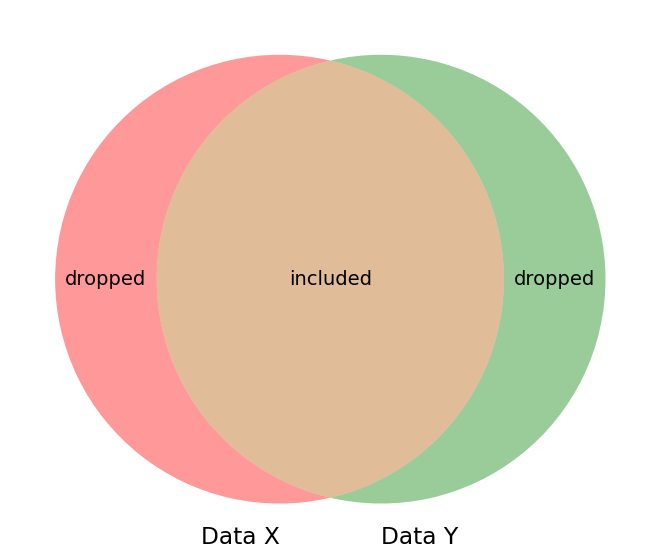

In [10]:
plt.figure(figsize=(15,7))
v = venn2(subsets = (4, 4, 10), set_labels = ('Data X', 'Data Y'))
v.get_label_by_id('100').set_text('dropped')
v.get_label_by_id('010').set_text('dropped' )
v.get_label_by_id('110').set_text('included')
plt.show()

Here we are dropping elements from both data set X and data set Y. A left join would keep all observations in data X intact and subset only from Y. 

Make sure that your resulting data sets have the correct number of rows and columns. That is, be clear about which observations are thrown away. 

**Note:** Don't make Venn diagrams in your own data project. It is just for exposition. 

# Analysis

To get a quick overview of the data, we show some **summary statistics** on a meaningful aggregation. 

To find a relationship between the fertility and amount of people with a higher education, we plot the development in fertility and education in the same coordinatsystem. 

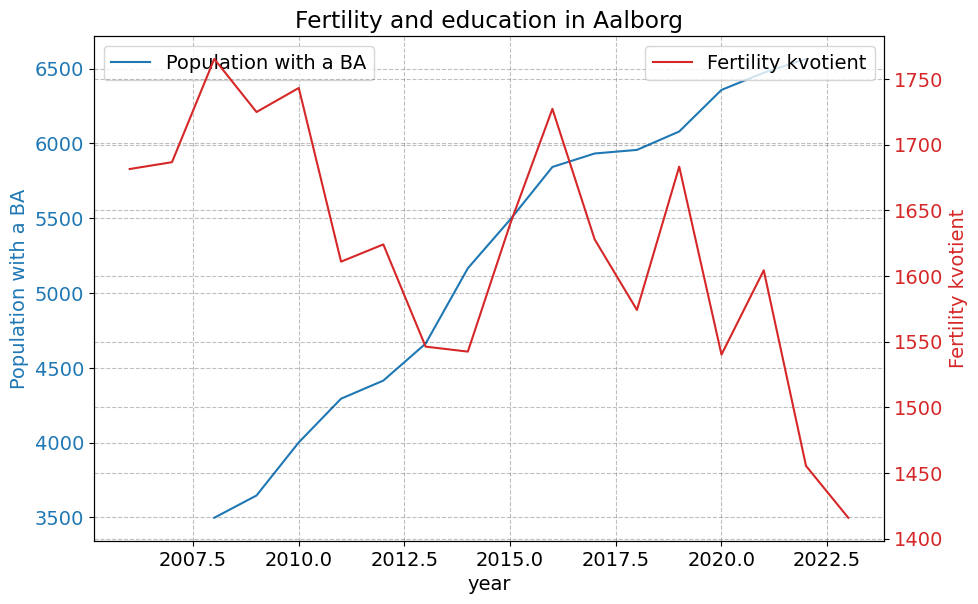

In [11]:
from dataproject import plot_fer_BA_copenhagen

# Call the function to plot
plot_fer_BA_copenhagen(ind_api, fert_api)

From the graph above, it can be hard to determine, if there is a relationship between how many people have a higher education and the fertility kvotient. From 2006-2020 the fertility seemed rather constant. However, it fell drastically in 2020. In the same period, the amount of people with a BA increased significantly compared to prior years. This could indicate, that when people take a longer education, they get fewer kids. 

We want to determine, if the same relationsship is evident in Thisted and Aalborg. 

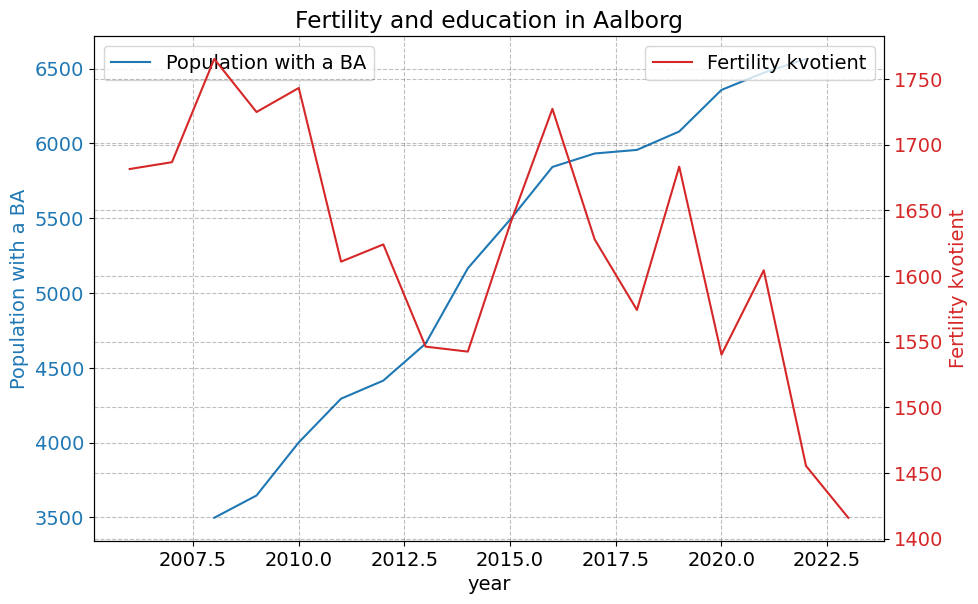

In [12]:
from dataproject import plot_fer_BA_aalborg

# Call the function to plot
plot_fer_BA_aalborg(ind_api, fert_api)




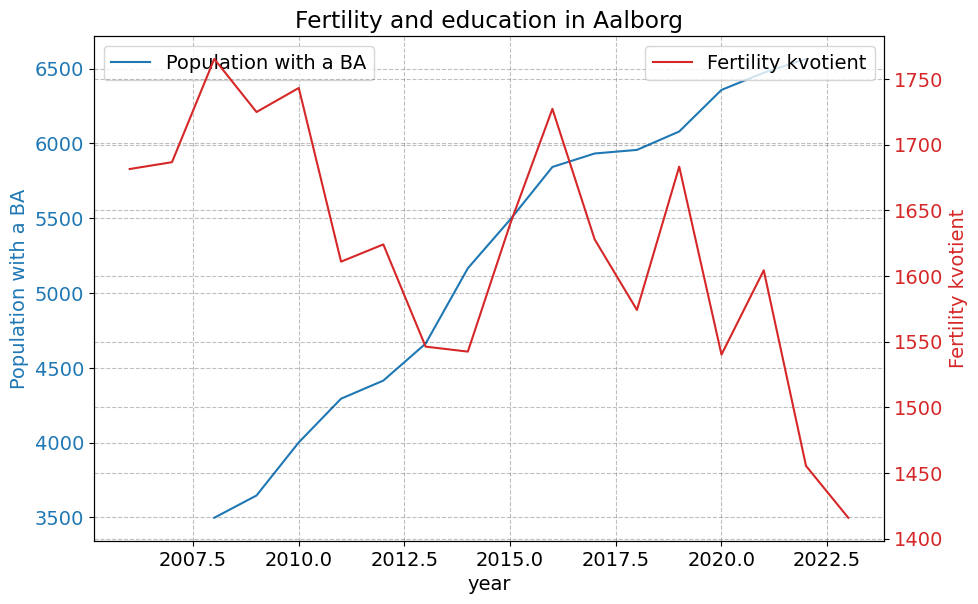

In [13]:
from dataproject import plot_fer_BA_aalborg

# Call the function to plot
plot_fer_BA_copenhagen(ind_api, fert_api)

The data from Thisted and Aalborg shows the same as Copenhagen. For the last years, people have been taking longer education, which might have led to a decrease in fertility. Especially in the last few years, the amount of people with a bachelor education has increased significantly and the fertilitykvotient has decreased a lot. 

# Conclusion

ADD CONCISE CONLUSION.

From our analysis we can conclude, that there might be a negative relationship between taking a longer education and the fertility. 